# Select the data

In [6]:
import pickle
import numpy as np
from eeg_research.system.bids_selector import BidsArchitecture
import mne
import scipy
import matplotlib.pyplot as plt
import alternate_isc as aisc
import inter_subject_correlation as isc
from pathlib import Path
root_directory = Path("/data2/Projects/eeg_fmri_natview/derivatives/")
architecture = BidsArchitecture(
    root = root_directory,
    session = '01',
    task = 'rest',
    run = '01',
    datatype = 'eeg',
    description= 'IscBandsEnvBk',
    suffix = 'eeg',
    extension = 'pkl',
)

In [7]:
with open(architecture.database.iloc[0]['filename'], 'rb') as f:
        indiv_dat = pickle.load(f)

In [9]:
data['feature_info']['projections'].shape

(62, 62, 5)

In [1]:
import pickle
import numpy as np
from eeg_research.system.bids_selector import BidsArchitecture
import mne
import scipy
import matplotlib.pyplot as plt
import alternate_isc as aisc
import inter_subject_correlation as isc
from pathlib import Path
import matplotlib.backends.backend_pdf as backend_pdf
from scipy.signal import butter, filtfilt, iirnotch
bands = {'delta': 0,
       'theta': 1,
       'alpha': 2,
       'beta': 3,
       'gamma': 4
}
band = 'gamma'
pdf = backend_pdf.PdfPages(f'isc_sources_for_{band}_rest.pdf')

data = list()
length_time = list()
mask = list()
data_dict = {}

for i, file in architecture.database.iterrows():
    with open(file['filename'], 'rb') as read_file:
        indiv_dat = pickle.load(read_file)
    #indiv_dat['feature'][:,~indiv_dat['mask']] = np.nan
    #indiv_dat['time'][~indiv_dat['mask']] = np.nan
    
    length_time.append(indiv_dat['feature'].shape[1])
    length_time.append(indiv_dat['mask'].shape[0])
    data.append(indiv_dat['feature'][:,:,bands[band]])
    mask.append(indiv_dat['mask'])

min_shape = min(length_time)
for idx in range(len(data)):
    data[idx] = data[idx][:,250:min_shape-250]
    mask[idx] = mask[idx][250:min_shape-250]
    
times = indiv_dat['time'][250:min_shape-250]
data = np.stack(data)
mask = np.stack(mask)

W, ISC, A, Y, Yfull = isc.calc_corrca(np.squeeze(data),
                                      times,
                                      mask = mask,
                                      riemann = False,
                                      **{'response_window': (times[0], times[-1]),
                                         'gamma': 0.05,
                                         'K': None,
                                         'stats': False,
                                         },
)


NameError: name 'architecture' is not defined

In [17]:
def plot_projections(projections, nb_features: int = 4,saving_filename = None, save = False, task = ''):
    mne.set_log_level('CRITICAL')
    bands_name = ['delta','theta','alpha','beta','gamma']
    for band in range(5):
        topo_fig, topo_axes = plt.subplots((nb_features // 5), 5, figsize = (12,(nb_features // 5) + 3))
        A = projections[:,:,band]
        montage = mne.channels.make_standard_montage('easycap-M1')
        info = mne.create_info(indiv_dat['labels']['channels_info']['channel_name'], sfreq = 1, ch_types='eeg')
        d = mne.io.RawArray(A,info)
        d.set_montage(montage)
        for idx in range(nb_features):
            mne.viz.plot_topomap(A[:,idx],
                                pos = d.info, 
                                axes = topo_axes.flatten()[idx],
                                show = False,
                                )
            topo_axes.flatten()[idx].set_title(f'Feature {idx + 1}')
        if nb_features % 5 != 0:
            [ax.set_visible(False) for ax in topo_axes.flatten()[nb_features:]]
        plt.suptitle(f'Features Scalp Projections {bands_name[band].capitalize()} for {task.capitalize()}')
        plt.tight_layout()
        plt.show()
        if save:
            topo_fig.savefig(f'../figures/scalp_projections_{bands_name[band]}_{task}.png')
        plt.close()

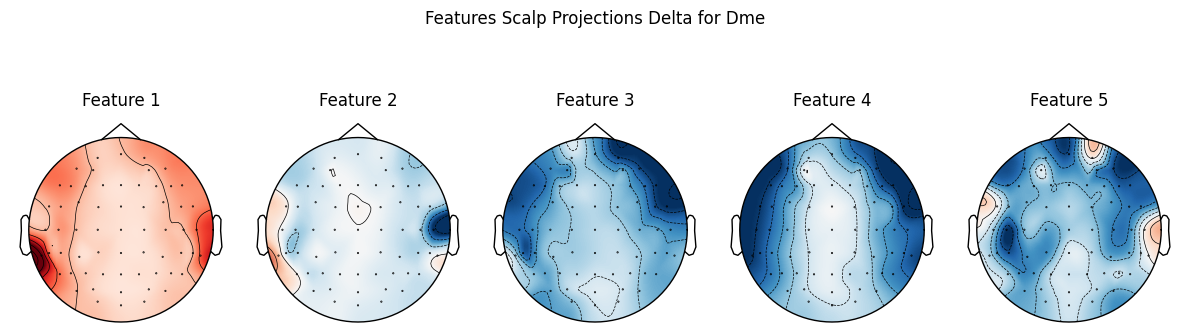

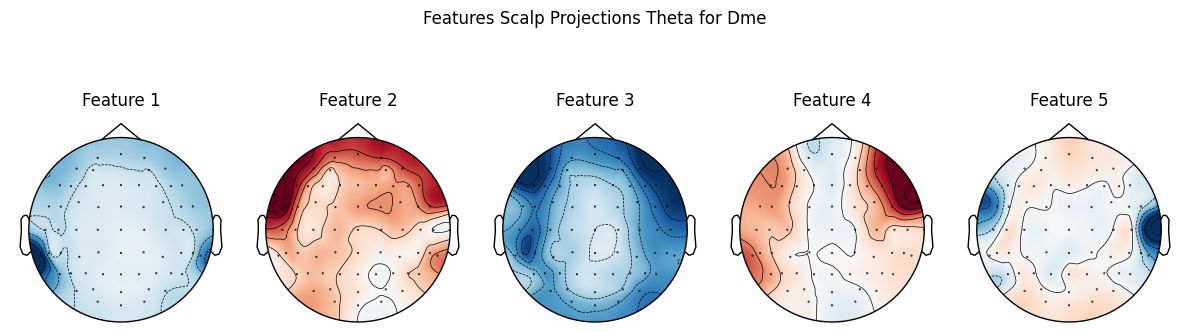

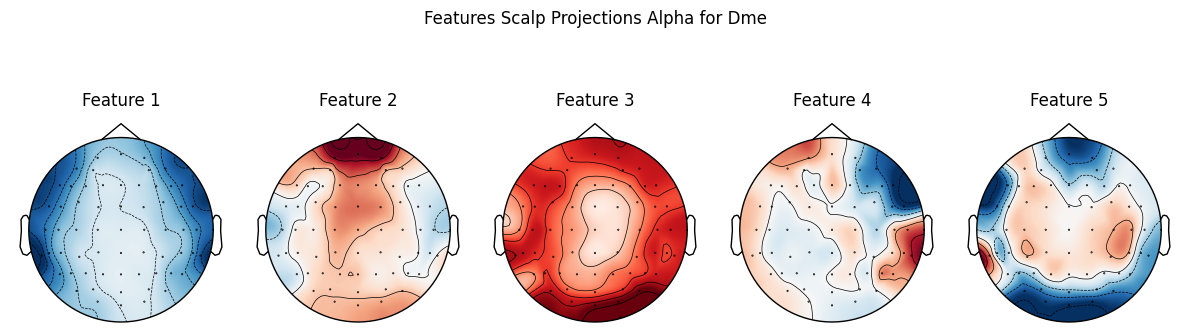

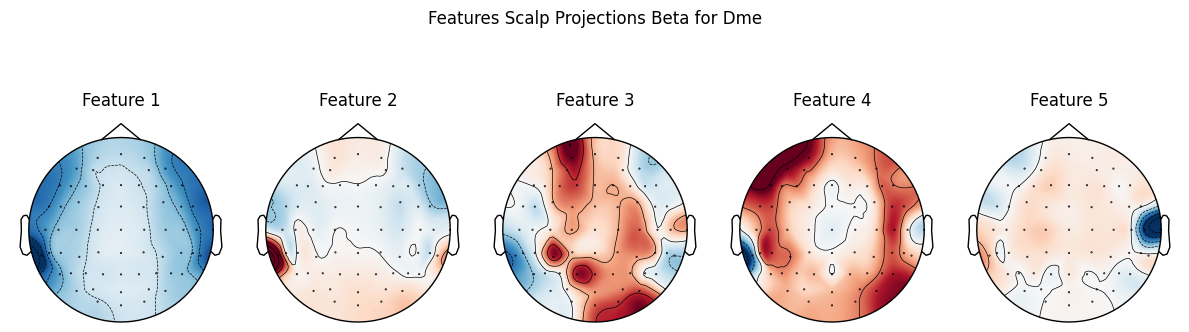

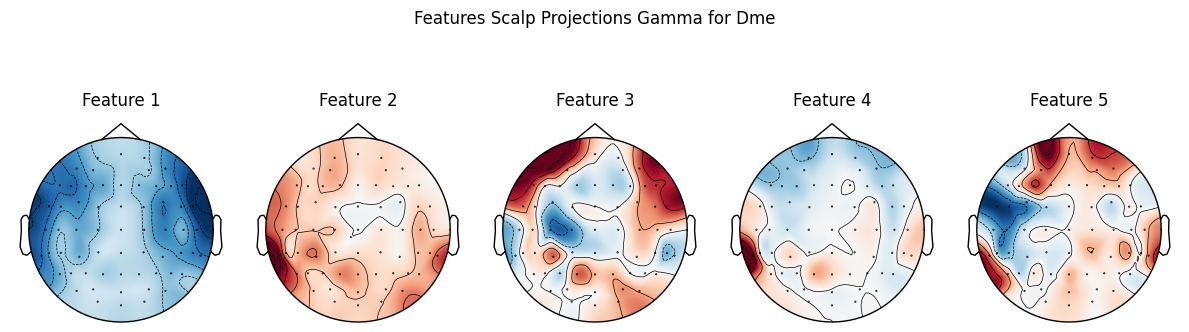

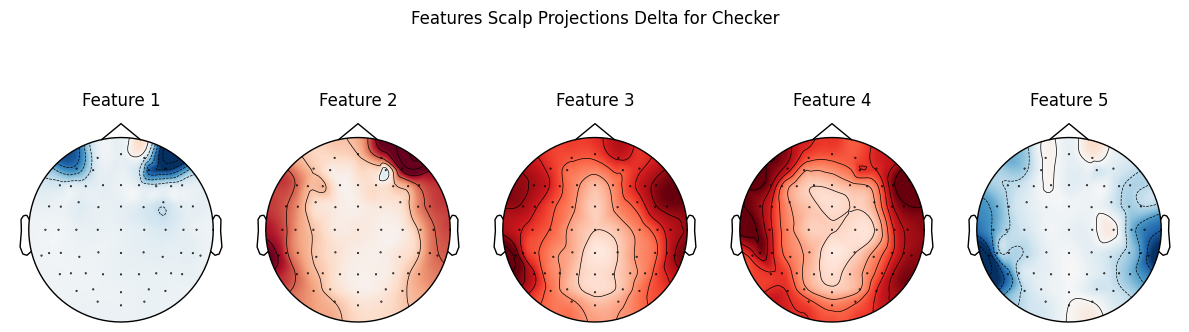

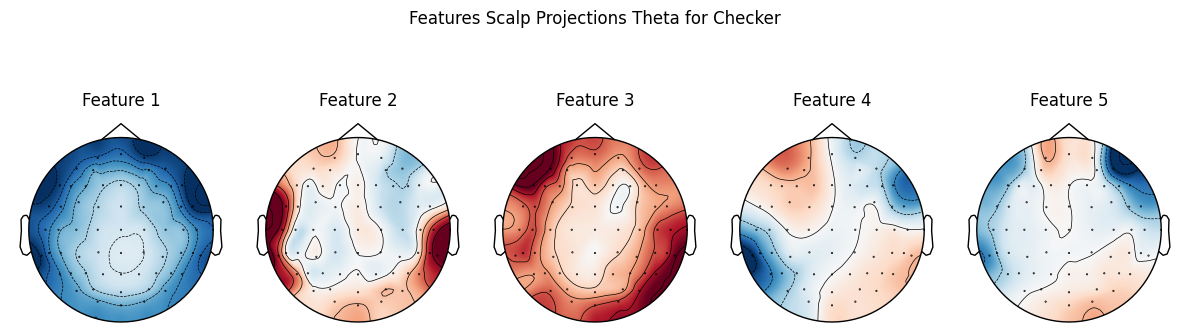

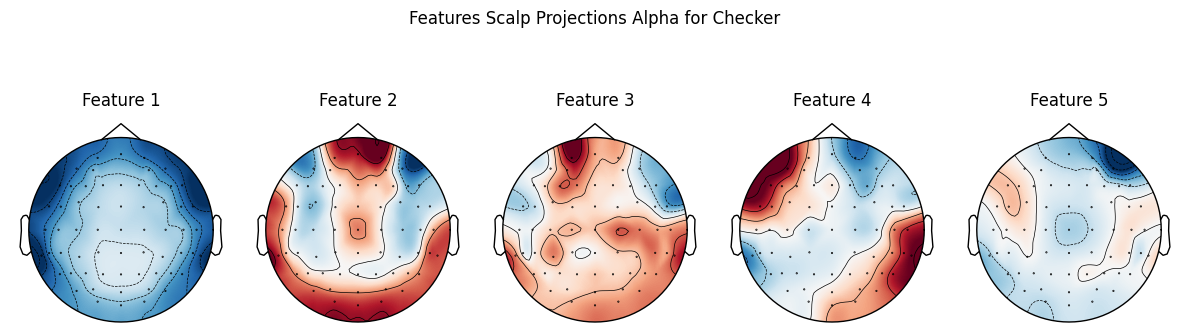

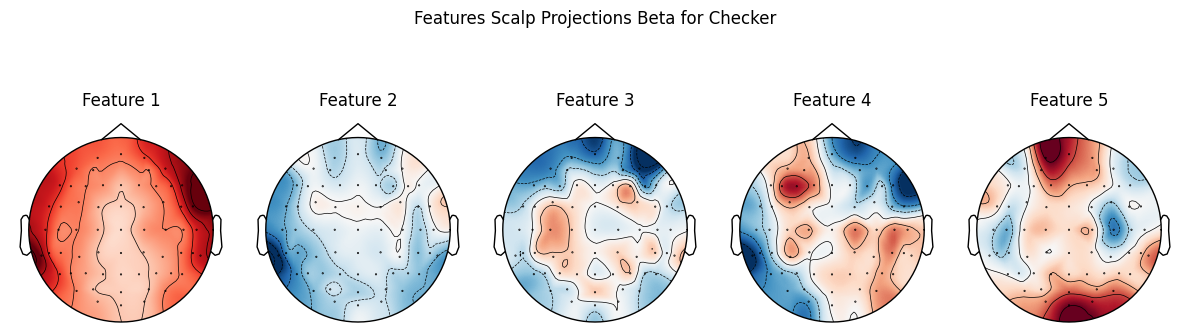

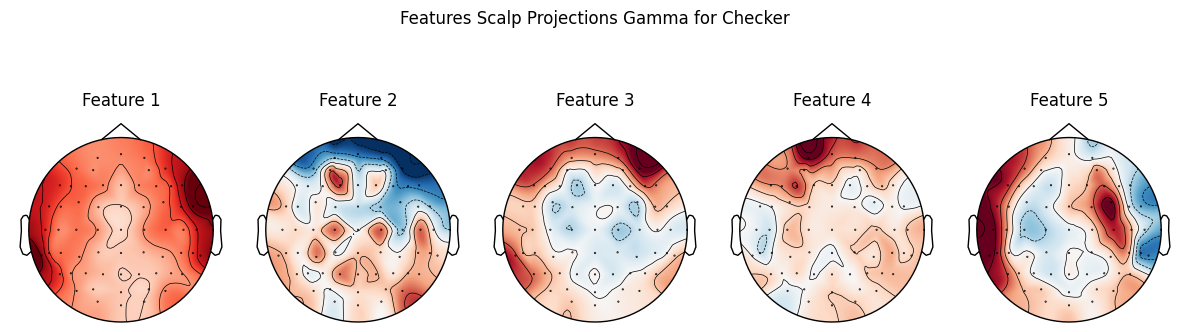

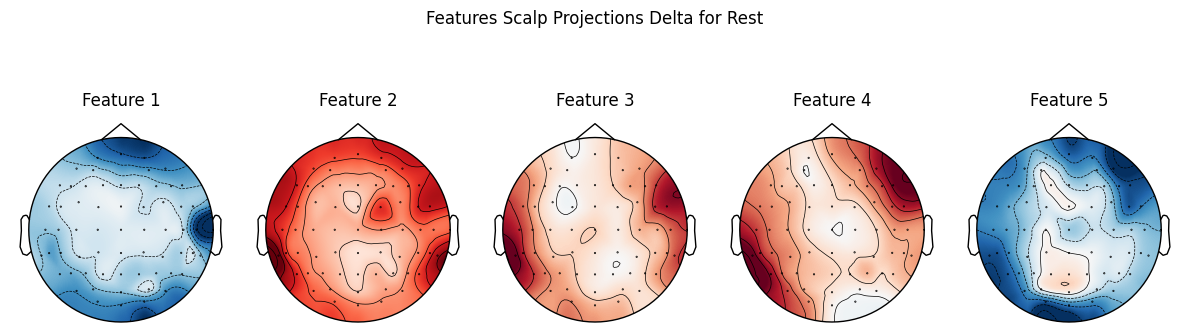

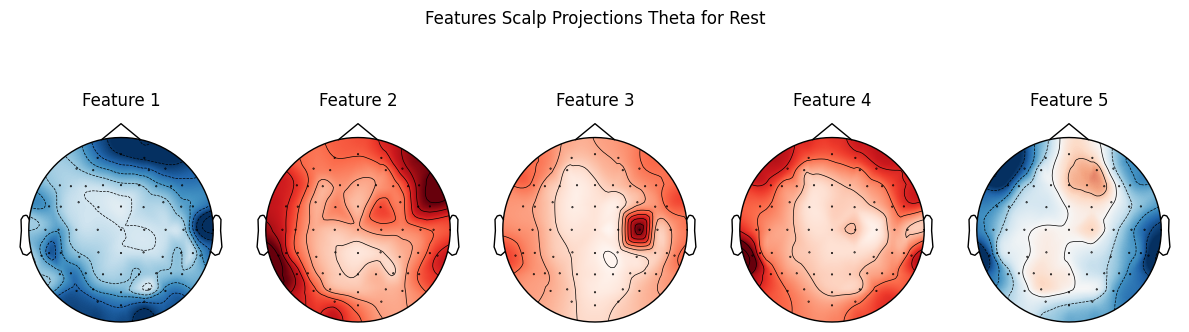

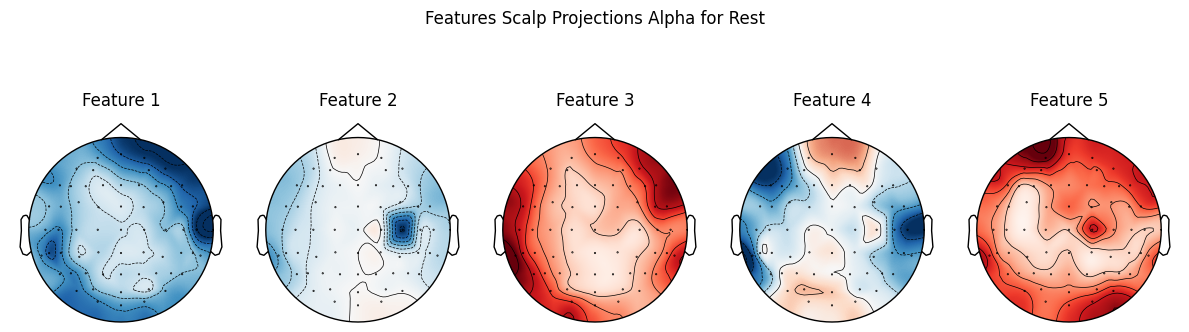

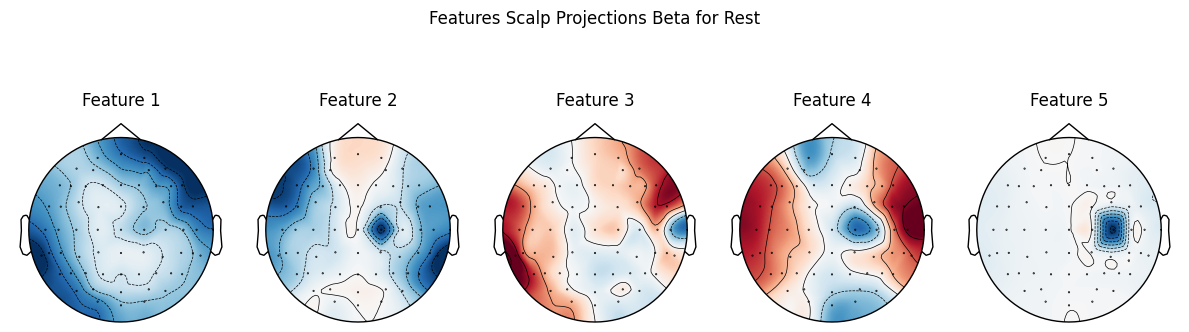

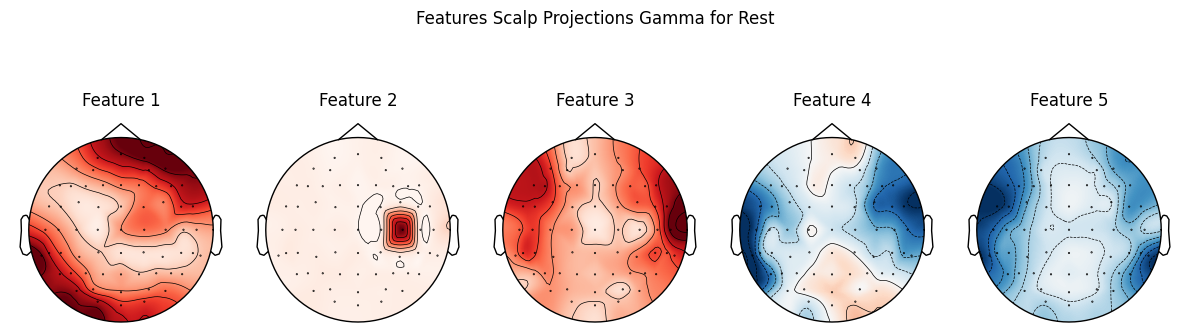

In [19]:
for task in ['dme','checker','rest']:
    architecture = BidsArchitecture(
        root = root_directory,
        session = '01',
        task = task,
        run = '01',
        datatype = 'eeg',
        description= 'IscBandsEnvBk',
        suffix = 'eeg',
        extension = 'pkl',
    )
    with open(architecture.database.iloc[0]['filename'], 'rb') as f:
            data = pickle.load(f)
    plot_projections(data['feature_info']['projections'], task=task, save = True, nb_features = 5)


In [1]:
import pickle
import numpy as np
from eeg_research.system.bids_selector import BidsArchitecture
import mne
import scipy
import matplotlib.pyplot as plt
import inter_subject_correlation as isc_obj
from pathlib import Path
from eeg_research.system.bids_selector import BidsPath
task = 'checker'
root_directory = Path("/data2/Projects/eeg_fmri_natview/derivatives/")
#for task in ['checker','rest','dme']:
architecture = BidsArchitecture(
    root = root_directory,
    session = '01',
    task = task,
    run = '01',
    datatype = 'eeg',
    description= 'BandsEnvBk',
    suffix = 'eeg',
    extension = 'pkl',
)
bands = {'delta': 0,
    'theta': 1,
    'alpha': 2,
    'beta': 3,
    'gamma': 4
}
features = []
masks = []
times = []
filters = []
isc = []
projections = []
for band in bands.keys():
    data = list()
    length_time = list()
    mask = list()
    time = []
    data_dict = {}

    for i, file in architecture.database.iterrows():
        with open(file['filename'], 'rb') as read_file:
            indiv_dat = pickle.load(read_file)
        #indiv_dat['feature'][:,~indiv_dat['mask']] = np.nan
        #indiv_dat['time'][~indiv_dat['mask']] = np.nan
        
        length_time.append(indiv_dat['feature'].shape[1])
        length_time.append(indiv_dat['mask'].shape[0])
        data.append(indiv_dat['feature'][:,:,bands[band]])
        mask.append(indiv_dat['mask'])
        time.append(indiv_dat['time'])

    min_shape = min(length_time)
    for idx in range(len(data)):
        data[idx] = data[idx][:,:min_shape]
        mask[idx] = mask[idx][:min_shape]
        time[idx] = time[idx][:min_shape]
        
    data = np.stack(data)
    mask = np.stack(mask)

    W, ISC, A, Y, Yfull = isc_obj.calc_corrca(np.squeeze(data),
                                        time[0],
                                        mask = mask,
                                        riemann = False,
                                        **{'response_window': (time[0][0], time[0][-1]),
                                            'gamma': 0.05,
                                            'K': None,
                                            'stats': False,
                                            },
    )
    pass

    #populate data and calculate ISC
    #stack to last dimension the freq bands
    filters.append(W)
    isc.append(ISC)
    projections.append(A)
    features.append(Y)
    masks.append(mask)


features = np.stack(features, axis = -1)
isc = np.stack(isc, axis = -1)
isc = isc[:, np.newaxis, :]
projections = np.stack(projections, axis = -1)
filters = np.stack(filters, axis = -1)

#plot_projections(save = True)

#for i, file in architecture.database.iterrows():
#    data_dict['time'] = time[i]
#    data_dict['feature'] = np.squeeze(features[i,:,:,:])
#    
#    data_dict['labels'] = {
#        'channels_info': {
#            'index': np.arange(features[i,:,:,:].shape[0]),
#            'channel_names': [f"source_{s}" for s in range(1,features[i,:,:,:].shape[0]+1)],
#        },
#        'frequencies': indiv_dat['labels']['frequencies'],
#    }

#    data_dict['feature_info'] = {
#        'info': 'Sources obtained from Inter Subject Correlation',
#        'isc': isc,
#        'projections': projections,
#        'filters': filters,
#    }

#    data_dict['mask'] = mask[i,:]
        
#for i, file in architecture.database.iterrows():
#    data_dict['time'] = time[i]
#    data_dict['feature'] = np.squeeze(features[i,:,:,:])
#    
#    data_dict['labels'] = {
#        'channels_info': {
#            'index': np.arange(features[i,:,:,:].shape[0]),
#            'channel_names': [f"source_{s}" for s in range(1,features[i,:,:,:].shape[0]+1)],
#        },
#        'frequencies': indiv_dat['labels']['frequencies'],
#    }
#
#    data_dict['feature_info'] = {
#        'info': 'Sources obtained from Inter Subject Correlation',
#        'isc': isc,
#        'projections': projections,
#        'filters': filters,
#    }
#
#    data_dict['mask'] = mask[i,:]
#        
#        
#    path = BidsPath(
#        root = root_directory,
#        subject = file['subject'],
#        session = file['session'],
#        datatype = file['datatype'],
#        task = file['task'],
#        run = file['run'],
#        description = f"Isc{file['description']}",
#        suffix = file['suffix'],
#        extension = 'pkl',
#    )
    
    #print(f"File will be saved at: {path.fullpath}")
    #print(f"Time shape: {data_dict['time'].shape}")
    #print(f"Feature shape: {data_dict['feature'].shape}")
    #print(f"Channels indices shape: {data_dict['labels']['channels_info']['index'].shape}")
    #print(f"Channels names shape: {len(data_dict['labels']['channels_info']['channel_names'])}")
    #print(f"Channels names values: {data_dict['labels']['channels_info']['channel_names']}")
    #print(f"Feature info: {data_dict['feature_info']}")
    #print(f"Mask shape: {data_dict['mask'].shape}")

    #path.fullpath.parent.mkdir(parents = True, exist_ok = True)
    #with open(path.fullpath, 'wb') as saving_file:
    #    pickle.dump(data_dict, saving_file)
    




KeyboardInterrupt: 

# Plot Features

In [ ]:
import matplotlib.backends.backend_pdf as backend_pdf
from scipy.signal import butter, filtfilt, iirnotch
bands = {'delta': 0,
       'theta': 1,
       'alpha': 2,
       'beta': 3,
       'gamma': 4
}
band = 'gamma'
#pdf = backend_pdf.PdfPages(f'isc_sources_for_{band}_rest.pdf')

data = list()
length_time = list()
mask = list()
data_dict = {}

for i, file in architecture.database.iterrows():
    with open(file['filename'], 'rb') as read_file:
        indiv_dat = pickle.load(read_file)
    #indiv_dat['feature'][:,~indiv_dat['mask']] = np.nan
    #indiv_dat['time'][~indiv_dat['mask']] = np.nan
    
    length_time.append(indiv_dat['feature'].shape[1])
    length_time.append(indiv_dat['mask'].shape[0])
    data.append(indiv_dat['feature'][:,:,bands[band]])
    mask.append(indiv_dat['mask'])

min_shape = min(length_time)
for idx in range(len(data)):
    data[idx] = data[idx][:,250:min_shape-250]
    mask[idx] = mask[idx][250:min_shape-250]
    
times = indiv_dat['time'][250:min_shape-250]
data = np.stack(data)
mask = np.stack(mask)

W, ISC, A, Y, Yfull = isc.calc_corrca(np.squeeze(data),
                                      times,
                                      mask = mask,
                                      riemann = False,
                                      **{'response_window': (times[0], times[-1]),
                                                'gamma': 0.05,
                                                'K': None,
                                                'stats': False,
                                                },
)

cutoff = 0.5
fs = 250 
order = 4 
nyquist = 0.5 * fs  
normal_cutoff = cutoff / nyquist  
b, a = butter(order, normal_cutoff, btype='low', analog=False)
filtered_data = filtfilt(b, a, Y)


montage = mne.channels.make_standard_montage('easycap-M1')
info = mne.create_info(indiv_dat['labels']['channels_info']['channel_name'], sfreq = 1, ch_types='eeg')
d = mne.io.RawArray(A,info)
d.set_montage(montage)
    
def plot_features(nb_features: int = 4, nb_subjects: int = 1, saving_filename = None, save = False):
    topo_fig, topo_axes = plt.subplots((nb_features // 5) + 1, 5, figsize = (12,(nb_features // 5) + 3))
    for idx in range(nb_features):
        print(topo_axes.shape)
        mne.viz.plot_topomap(A[:,idx],
                             pos = d.info, 
                             axes = topo_axes.flatten()[idx],
                             show = False,
                             )
        topo_axes.flatten()[idx].set_title(f'Feature {idx + 1}')
    if nb_features % 5 != 0:
        [ax.set_visible(False) for ax in topo_axes.flatten()[nb_features:]]
    plt.suptitle('Features scalp projections')
    if save:
        pdf.savefig()
    plt.show()
    plt.close()
    for subject_idx in range(nb_subjects):
        fig, axes = plt.subplots(1,2, figsize= (12, 5),sharey=True)
        axes[0].plot(times[mask[subject_idx,:]],Y[subject_idx,:nb_features, mask[subject_idx,:]])
        axes[0].set_title('Raw')
        axes[0].set_xlabel('Time (seconds)')
        axes[0].set_ylabel('Correlation with population (A.U)')
        axes[1].plot(times[mask[subject_idx,:]], filtered_data[subject_idx,:nb_features, mask[subject_idx,:]])
        axes[1].set_title('Filtered: low-pass 0.5 Hz')

        plt.legend([f"Feature {ft+1}" for ft in range(nb_features)])
        plt.tight_layout()

        plt.suptitle(f'{nb_features} first features for subject {subject_idx + 1:01}')
        if save:
            pdf.savefig(fig)
        #fig.savefig(f"/home/slouviot/01_projects/eeg_brain_state_prediction/figures/sub-{subject_idx+1:01}_ISC_plot.png")
    
    if save: 
        pdf.close()

plot_features(3,20)


# Plot Features

In [ ]:
from scipy.signal import butter, filtfilt
cutoff = 0.5
fs = 250 
order = 4 
nyquist = 0.5 * fs  
normal_cutoff = cutoff / nyquist  
b, a = butter(order, normal_cutoff, btype='low', analog=False)
filtered_data = filtfilt(b, a, Y)

montage = mne.channels.make_standard_montage('easycap-M1')
info = mne.create_info(indiv_dat['labels']['channels_info']['channel_name'], sfreq = 1, ch_types='eeg')
d = mne.io.RawArray(A,info)
d.set_montage(montage)
    
def plot_features(nb_features: int = 4, nb_subjects: int = 1):
    topo_fig, topo_axes = plt.subplots((nb_features // 5) + 1, 5, figsize = (12,(nb_features // 5) + 3))
    for idx in range(nb_features):
        print(topo_axes.shape)
        mne.viz.plot_topomap(A[:,idx],
                             pos = d.info, 
                             axes = topo_axes.flatten()[idx],
                             show = False,
                             )
        topo_axes.flatten()[idx].set_title(f'Feature {idx + 1}')
    if nb_features % 5 != 0:
        [ax.set_visible(False) for ax in topo_axes.flatten()[nb_features:]]
    plt.suptitle('Features scalp projections')
    plt.show()
    for subject_idx in range(nb_subjects):
        fig, axes = plt.subplots(1,2, figsize= (12, 5),sharey=True)
        axes[0].plot(times[mask[subject_idx,:]],Y[subject_idx,:nb_features, mask[subject_idx,:]])
        axes[0].set_title('Raw')
        axes[0].set_xlabel('Time (seconds)')
        axes[0].set_ylabel('Correlation with population (A.U)')
        axes[1].plot(times[mask[subject_idx,:]], filtered_data[subject_idx,:nb_features, mask[subject_idx,:]])
        axes[1].set_title('Filtered: low-pass 0.5 Hz')

        plt.legend([f"Feature {ft+1}" for ft in range(nb_features)])
        fig.savefig(f"/home/slouviot/01_projects/eeg_brain_state_prediction/figures/sub-{subject_idx+1:01}_ISC_plot.png")
        plt.suptitle(f'{nb_features} first features for subject {subject_idx + 1:01}')

plot_features(3,20)


# ISC (Rest)

In [25]:
W, ISC, A, Y, Yfull = isc.calc_corrca(np.squeeze(data),times,
                                      mask = mask,
                                      riemann = False,
                                      **{'response_window': (times[0], times[-1]),
                                                'gamma': 0.05,
                                                'K': None,
                                                'stats': False,
                                                },
)


(22, 62, 150200)
N: 22, D: 62, T:150200
Rw: (62, 62), Rt: (62, 62), Rb: (62, 62)
Rank: 62


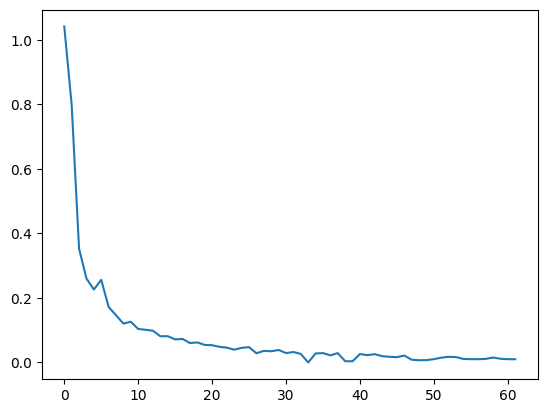

In [26]:
plt.plot(ISC)

# Plot Features

In [ ]:
from scipy.signal import butter, filtfilt
cutoff = 0.5
fs = 250 
order = 4 
nyquist = 0.5 * fs  
normal_cutoff = cutoff / nyquist  
b, a = butter(order, normal_cutoff, btype='low', analog=False)
filtered_data = filtfilt(b, a, Y)

montage = mne.channels.make_standard_montage('easycap-M1')
info = mne.create_info(indiv_dat['labels']['channels_info']['channel_name'], sfreq = 1, ch_types='eeg')
d = mne.io.RawArray(A,info)
d.set_montage(montage)
    
def plot_features(nb_features: int = 4, nb_subjects: int = 1):
    topo_fig, topo_axes = plt.subplots((nb_features // 5) + 1, 5, figsize = (12,(nb_features // 5) + 3))
    for idx in range(nb_features):
        print(topo_axes.shape)
        mne.viz.plot_topomap(A[:,idx],
                             pos = d.info, 
                             axes = topo_axes.flatten()[idx],
                             show = False,
                             )
        topo_axes.flatten()[idx].set_title(f'Feature {idx + 1}')
    if nb_features % 5 != 0:
        [ax.set_visible(False) for ax in topo_axes.flatten()[nb_features:]]
    plt.suptitle('Features scalp projections')
    plt.show()
    #for subject_idx in range(nb_subjects):
    #    fig, axes = plt.subplots(1,2, figsize= (12, 5),sharey=True)
    #    axes[0].plot(times[mask[subject_idx,:]],Y[subject_idx,:nb_features, mask[subject_idx,:]])
    #    axes[0].set_title('Raw')
    #    axes[0].set_xlabel('Time (seconds)')
    #    axes[0].set_ylabel('Correlation with population (A.U)')
    #    axes[1].plot(times[mask[subject_idx,:]], filtered_data[subject_idx,:nb_features, mask[subject_idx,:]])
    #    axes[1].set_title('Filtered: low-pass 0.5 Hz')

    #    plt.legend([f"Feature {ft+1}" for ft in range(nb_features)])
    #    fig.savefig(f"/home/slouviot/01_projects/eeg_brain_state_prediction/figures/sub-{subject_idx+1:01}_ISC_plot.png")
    #    plt.suptitle(f'{nb_features} first features for subject {subject_idx + 1:01}')

plot_features(3,20)


# Run Predictions
This is a temporary patch for going around the strictness of pybids.

## Create Dictionaries

In [6]:
for saving_filename, data in data_dict.items():
    data.update({'feature':Y[idx,:,:]})
    #with open(saving_filename,'wb') as saver:
        #pickle.dump(data,saver)

In [7]:
data

{'time': array([0.00000e+00, 2.00000e-03, 4.00000e-03, ..., 6.04796e+02,
        6.04798e+02, 6.04800e+02]),
 'labels': {'channels_info': {'index': [0,
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    39,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61],
   'channel_name': ['Fp1',
    'Fp2',
    'F3',
    'F4',
    'C3',
    'C4',
    'P3',
    'P4',
    'O1',
    'O2',
    'F7',
    'F8',
    'T7',
    'T8',
    'P7',
    'P8',
    'Fz',
    'Cz',
    'Pz',
    'Oz',
    'FC1',
    'FC2',
    'CP1',
    'CP2',
    'FC5',
    'FC6',
    'CP5',
    'CP6',
    'TP9',
    'TP10',
    'POz',
    'F1',
    'F2',
    'C1'

## Classic naive resampling at 3.8 Hz

In [ ]:
from scipy.interpolate import CubicSpline
import numpy as np
from eeg_research.system.bids_selector import BIDSselector
import pickle
from pathlib import Path
from collect_multimodal_refact *
root = "/data2/Projects/eeg_fmri_natview/derivatives"
selector = BIDSselector(
    root,
    subject="*",
    task=["checker", "rest"],
    extension=".pkl",
    datatype="eeg",
    suffix="eeg",
)
files = selector.layout
multimodal = {}
resampling_factor = 8

for file in files:
    eeg_descriptions = [
        "bandsEnv",
        "customEnv",
        "gfp",
    ]
        
    for eeg_description in eeg_descriptions:
        if eeg_description in file:
            print('\nReading:')
            for modality in ["eeg", "brainstates", "eyetracking"]:
                fname = rename_fname(file, modality,eeg_description)
                if modality_file_exists(file, modality):
                    print(fname)
                    with open(fname, "rb") as data_file:
                        data = pickle.load(data_file)

                    resampled_time = resample_time(
                        data["time"],
                        tr_value=2.1,
                        resampling_factor=resampling_factor,
                    )

                    data.update(
                        {
                            "feature": resample_data(
                                data["feature"], data["time"], resampled_time
                            ),
                            "time": resampled_time,
                        }
                    )

                    multimodal[modality] = data

            for modality, data in multimodal.items():
                print(f"\n{str(modality).capitalize()} before triming")
                print(f'time shape: {data['time'].shape}')
                print(f'data shape: {data['feature'].shape}')

            trimed_multimodal = trim_to_min_time(multimodal_dict=multimodal)
            for modality, data in trimed_multimodal.items():
                print(f"\n{str(modality).capitalize()} after triming")
                print(f'time shape: {data['time'].shape}')
                print(f'data shape: {data['feature'].shape}')

            fname_placeholders = put_placeholders(file)
            for placeholder, value in zip(
                ["<datatype>", "<description>", "<suffix>"],
                ["multimodal", 
                    f"_desc-{eeg_description}{str(resampling_factor)}", 
                    "multimodal"],
            ):
                fname_placeholders = fname_placeholders.replace(placeholder, value)
            
            Path(fname_placeholders).parent.mkdir(parents=True, exist_ok=True)

            print(f"\nSaving to: {fname_placeholders}")
            with open(fname_placeholders, 'wb') as saving_file:
                pickle.dump(trimed_multimodal,saving_file)


In [19]:
from pathlib import Path
file = Path(selector.layout[0])

In [20]:
file.parent

PosixPath('/data2/Projects/eeg_fmri_natview/derivatives/sub-01/ses-01/eeg')

In [ ]:
def modify_filename(full_filename: str,
                    datatype: str,
                    extension: str):

    full_filename = Path(full_filename)
    path = full_filename.parent
    file = full_filename.name
    new_path = path.replace('eeg',datatype)
    idx_desc, idx_suffix = file.find('_desc-'), file.find('_eeg')
    modified_filename = file[:idx_desc] + file[idx_suffix:]
    for old_string, new_string in zip(['_eeg','pkl'],[datatype,extension]):
        modified_filename = modified_filename.replace(old_string, new_string)

sub-01_ses-01_task-checker_run-01_eyetracking.tsv


In [ ]:
print(new_filename)

sub-01_ses-01_task-checker_run-01_eyetracking.pkl


In [3]:
selector.suffix = "eyetracking"

In [4]:
selector.layout

['/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/fsaverage/mri/aparc+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/fsaverage/mri/aparc.a2005s+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/fsaverage/mri/aparc.a2009s+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/fsaverage/xhemi/mri/aparc+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/sub-01/label/lh.cortex+hipamyg.label',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/sub-01/label/rh.cortex+hipamyg.label',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/sub-01/mri/aparc+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/derivatives/sourcedata/freesurfer/sub-01/mri/aparc.a2009s+aseg.mgz',
 '/data2/Projects/eeg_fmri_natview/data/fmriprep/de

In [26]:
import pickle
import bids_explorer.architecture as arch
arch = arch.BidsArchitecture(
    root = "/data2/Projects/eeg_fmri_natview/derivatives",
    datatype = "multimodal",
    extension = "pkl",
)


In [27]:
arch.descriptions

['BandsEnvBk8Caps',
 'BandsEnvBk8Yeo7',
 'BandsGfpBk8Caps',
 'CustomEnvBk8Caps',
 'CustomEnvBk8Yeo7',
 'CustomGfpBk8Caps',
 'GfpBk8Caps',
 'IscBandsEnvBk8Caps']

In [25]:
desc = 'IscBandsEnvBk8'
for idx, file in arch:
    if file['description'] == desc:
        old_filename = file['filename']
        new_filename = old_filename.parent / old_filename.name.replace(desc,f'{desc}Caps')
        file['filename'].rename(new_filename)